In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
# import pygmo

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Local
from robustranking.benchmark import Benchmark
from robustranking.comparison import BootstrapComparison, SubSetComparison, AggregatedComparison
from robustranking.utils import *

ModuleNotFoundError: No module named 'pandas'

# Preprocess data

In [ ]:
def get_all_files(dir: Path, suffix=None) -> list:
    files = []
    for f in dir.iterdir():
        if f.is_dir():
            files += get_all_files(f, suffix)
        if f.is_file():
            files.append(f)
    if suffix is not None:
        files = [f for f in files if f.suffix == suffix]
    return files

def get_df(chunks: list) -> pd.DataFrame:
    mruns = []
    for c in chunks:
        iid = (Path(c).name)[:-8]+".tsp"
        mruns += [{"instance":iid, "pqr10":pqr, "seed": runid} for runid, pqr in enumerate(np.load(c).tolist())]
    mdf = pd.DataFrame(mruns)
    return mdf



In [ ]:
dfs = []
for solver in ["default", "smac", "smac2", "transformer"]:
    for dataset in ["rue", "netgen", "netgen_morphed", "tsplib", "tspworld", "vlsi-500-5000", "national-500-5000"]:
        result_dir = Path(f"moritz/{solver}/{dataset}")
        if not result_dir.exists():
            continue
        chunks = get_all_files(result_dir, suffix=".npy")
        mdf = get_df(chunks)
        if dataset in ["rue", "netgen", "netgen_morphed"]:
            mdf["dataset"] = [f"{dataset}_{i.split('-')[0]}" for i in mdf["instance"]]
        else:
            mdf["dataset"] = f"{dataset}"
        mdf["algorithm"] = f"{solver}"
        dfs.append(mdf)

df = pd.concat(dfs)
pqr_df = df.groupby(["algorithm", "dataset", "instance"])["pqr10"].apply(lambda x: pqr_score(x, cutoff=120, k=10))

In [ ]:
import pickle
with open("moritz/transformer/pqr10_scores_transvormer_v3.pickle", "rb") as fh:
    transformer = pickle.load(fh)
rows = []
for key, pqr10 in transformer.items():
    row = {
        "dataset": key.split("/")[0],
        "instance": key.split("/")[1],
        "pqr10": pqr10,
        "algorithm":"transformer"
    }
    
    if row["dataset"] in ["rue", "netgen", "netgen_morphed"]:
        row["dataset"] = row["dataset"] + "_" + key.split("/")[1].split("-")[0]
    row["dataset"] = row["dataset"].replace("tsp_world_2000", "tspworld")
    rows.append(row)

transformer = pd.DataFrame(rows).set_index(["algorithm", "dataset", "instance"]).squeeze()

pqr_df = pd.concat([pqr_df, transformer])

In [ ]:
pqr_df.groupby(["algorithm", "dataset"]).mean().unstack("algorithm").round(2)

In [ ]:
dataset_sizes = df.groupby("dataset")["instance"].nunique().to_dict()
to_df = (pqr_df > 120).groupby(["algorithm", "dataset"]).sum()
to_df.name = "TO"
to_df = to_df.to_frame()
to_df["TO"] = [float(to["TO"] / dataset_sizes[i[1]]) for i, to in to_df.iterrows()]
to_df = to_df.squeeze()
to_df

In [ ]:
res_df = pd.merge(pqr_df.groupby(["algorithm", "dataset"]).mean(), to_df, left_index=True, right_index=True)
res_df.unstack("algorithm").swaplevel(0,1,1).sort_index(axis=1)

In [ ]:
pqr_df.to_csv("performances_pqr.csv")
to_df.to_csv("performance_to.csv")

## Do testing
TSP configuration

In [ ]:
pqr_df = pd.read_csv("performances_pqr.csv")
to_df = pd.read_csv("performances_to.csv")

In [3]:
for dataset, runs in pqr_df.groupby("dataset"):
    runs = runs.reset_index()
    if runs["algorithm"].nunique() <= 1:
        continue
    benchmark = Benchmark()
    benchmark.from_pandas(runs, "algorithm", "instance", "pqr10")
    print(benchmark.show_stats())
    
    comparison = BootstrapComparison(benchmark,
                                 alpha=0.05,
                                 minimise=True,
                                 bootstrap_runs=10000,
                                 aggregation_method=np.mean)

    default_comparison = AggregatedComparison(benchmark,
                                              minimise=True,
                                              aggregation_method=np.mean)

    comparison.compute()
    robust_ranks = comparison.get_ranking()
    print(dataset)
    display(robust_ranks)

,Unnamed: 0,config,instance,validation,par10
0,0,0,subset_world_10027.tsp,False,658.67450
1,1,0,subset_world_10043.tsp,False,1200.00000
2,2,0,subset_world_10067.tsp,False,1200.00000
3,3,0,subset_world_10075.tsp,False,23.72725
4,4,0,subset_world_10082.tsp,False,1200.00000
...,...,...,...,...,...
71470,71470,9,subset_world_99898.tsp,False,52.56110
71471,71471,9,subset_world_99940.tsp,False,17.54615
71472,71472,9,subset_world_99943.tsp,False,24.52505
71473,71473,9,subset_world_99948.tsp,False,38.02830


## Make results table

In [ ]:
# Make 

## Make CD plots

In [ ]:
plot_distribution(comparison, "MapleCOMSPS_DRUPseq_LRB_VSIDS_drup")
plot_distribution(comparison, "YalSAT 03rdefault")

ValueError: Must pass 2-d input. shape=(1, 29, 3)

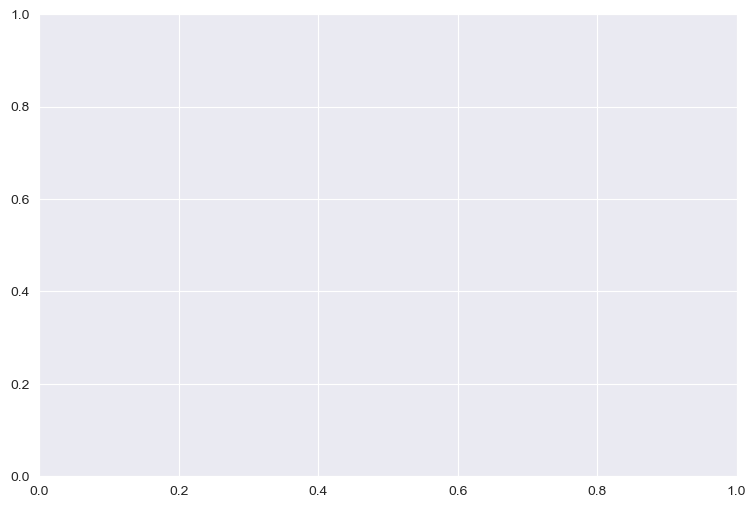

In [12]:
plot_distributions_comparison(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "Glucose_nbSatdefault"])

ValueError: Must pass 2-d input. shape=(1, 29, 3)

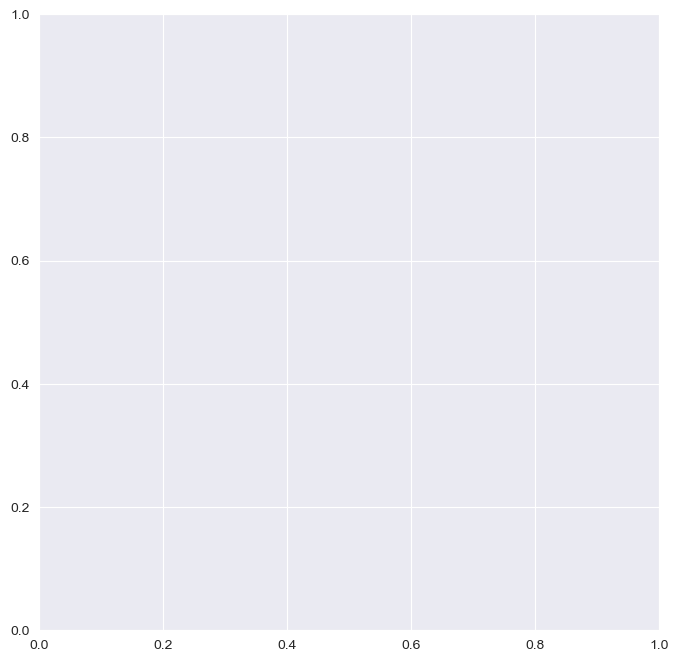

In [13]:
plot_ci_list(comparison)

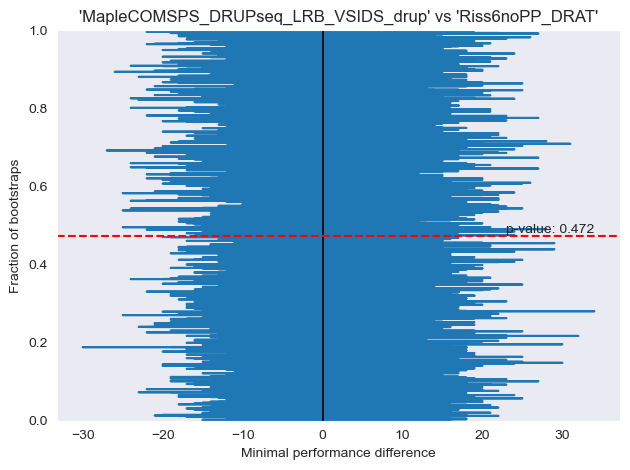

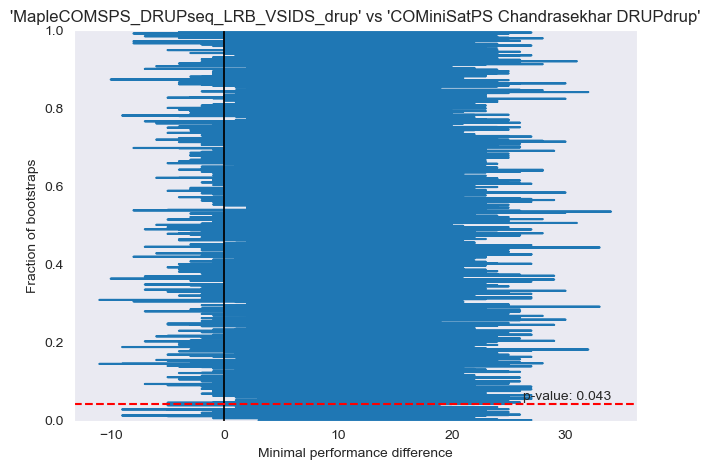

In [14]:
def plot_comparison_distribution(comparison, algorithms):
    cache = comparison._get_cache()
    s1 = cache["meta_data"]["algorithms"].index(algorithms[0])
    s2 = cache["meta_data"]["algorithms"].index(algorithms[1])

    distributions = cache["distributions"]
    p_value = comparison.statistical_test(*algorithms)
    direction = -1 if comparison.minimise else 1
    diff = direction * (distributions[s1,:] - distributions[s2,:])
    diff = np.sort(diff)
    plt.grid()
    plt.plot(diff, np.linspace(0, 1, len(diff)))
    plt.axvline(0, c="black", linewidth=1.25, linestyle="-")
    plt.axhline(p_value, c="red", linestyle="--")
    plt.text(diff.max() , p_value+0.01, f"p-value: {p_value:.3f}", ha="right")
    plt.title(f"'{algorithms[0]}' vs '{algorithms[1]}'")
    plt.xlabel("Minimal performance difference")
    plt.ylabel("Fraction of bootstraps")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


plot_comparison_distribution(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "Riss6noPP_DRAT"])
plot_comparison_distribution(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "COMiniSatPS Chandrasekhar DRUPdrup"])

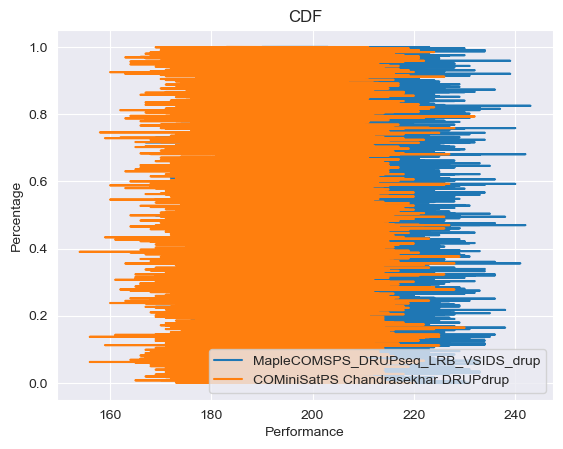

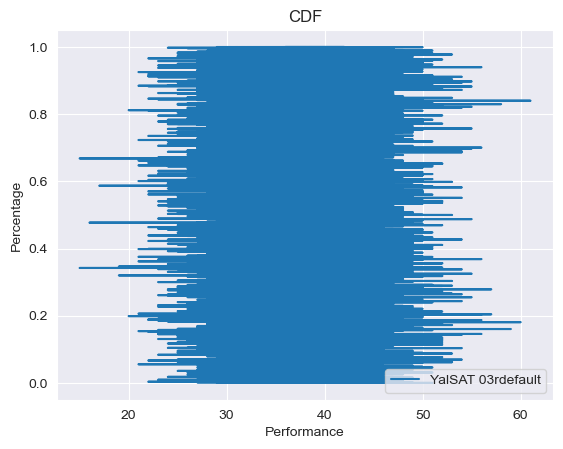

In [10]:
def plot_distribution_cdf(comparison, algorithms):
    cache = comparison._get_cache()
    distributions = cache["distributions"]

    if not isinstance(algorithms, list):
        algorithms = [algorithms]

    for algorithm in algorithms:
        s1 = cache["meta_data"]["algorithms"].index(algorithm)

        #direction = -1 if comparison.minimise else 1
        diff = distributions[s1,:]
        diff = np.sort(diff)
        plt.plot(diff, np.linspace(0, 1, len(diff)), label=algorithm)

    # plt.axhline(0, c="black", linewidth=1.25, linestyle="-")
    # plt.axvline(p_value, c="red", linestyle="--")
    # plt.text(p_value+0.01, diff.max(), f"p-value = {p_value:.3%}")
    plt.title("CDF")
    plt.xlabel("Performance")
    plt.ylabel("Percentage")
    plt.legend()
    plt.show()

plot_distribution_cdf(comparison, ["MapleCOMSPS_DRUPseq_LRB_VSIDS_drup", "COMiniSatPS Chandrasekhar DRUPdrup"])
plot_distribution_cdf(comparison, ["YalSAT 03rdefault"])

/Users/jeroen/Documents/Work/Projects/EmpiricalComparison/Experiments/robustranking/comparison.py:56: UserWarning: No results found. Start computations
  warnings.warn("No results found. Start computations")


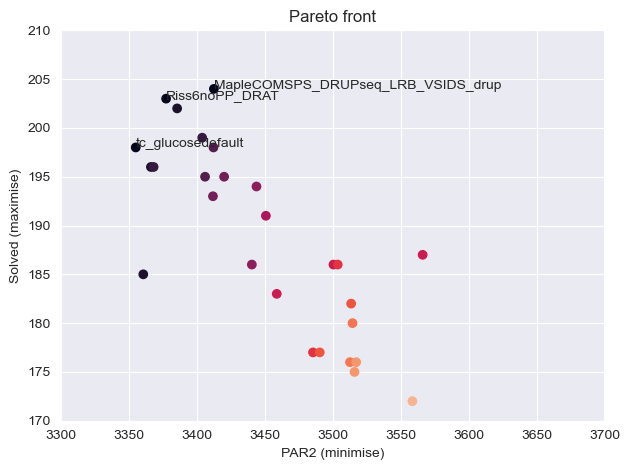

In [11]:
ddf = default_comparison.get_ranking().sort_values(("PAR2", "rank"))
points = ddf[[("PAR2", "score"), ("solved", "score")]].to_numpy()
points[:, 1] = -points[:, 1]
ranks, dl, dc, ndr = pygmo.fast_non_dominated_sorting(points)
ndr
plt.scatter(ddf[("PAR2","score")], ddf[("solved","score")], c=ndr)
for algindex in np.argwhere(ndr == 0):
    iloc = algindex[0]
    series = ddf.iloc[iloc]
    # print(series.name)
    # print(series[("PAR2","score")], series[("solved","score")], series.name)
    plt.text(series[("PAR2","score")], series[("solved","score")], series.name)
plt.title("Pareto front")
plt.xlim(3300, 3700)
plt.xlabel("PAR2 (minimise)")
plt.ylim(170, 210)
plt.ylabel("Solved (maximise)")
plt.tight_layout()
plt.show()